# Searching for sources of neutrinos in the IceCube data

*Fermi Summer School 2018*

Marcos Santander

**Disclaimer**: This tutorial is meant to give an idea of basic methods to look for sources. It *is not* meant to be a full implementation of the standard IceCube tools.

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import healpy as hp
import urllib
import matplotlib as mpl
import scipy as sp
from astropy.io import fits
from scipy.interpolate import interp1d, UnivariateSpline

pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['figure.figsize'] = (8, 6.0)
pl.rcParams['font.size'] = 18
pl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['font.family'] = 'CMU Sans Serif'

cmap_maps=pl.get_cmap("RdBu_r")
cmap_maps.set_bad('white')
cmap_maps.set_under('white')


degree = np.pi / 180.

## Getting the data

Let's get some data. The data that will be used here comes from the public release of the first year of IceCube data from the completed IC86 detector. The data was used in this paper: https://arxiv.org/abs/1406.6757 and additional details are provided in the public release page: https://icecube.wisc.edu/science/data/PS-IC86-2011

In [2]:
urllib.urlretrieve('http://www.nevis.columbia.edu/~santander/ic_events.txt', 'ic_events.txt')
icevents = np.genfromtxt("ic_events.txt", names=True)

There are 138322 neutrino event candidates in this set

In [3]:
len(icevents)

138322

## Plotting some variables

### Declination and energy distributions

Let's look at the distribution of event declinations in the data set. 

Text(0.5,0,'sin($\\delta$)')

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'CMU Sans Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


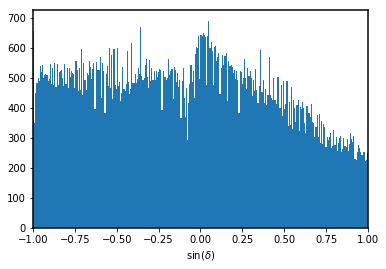

In [4]:
pl.hist(np.sin(icevents['Dec'] * degree),range=(-1,1),bins=300)
pl.xlim(-1,1)
pl.xlabel('sin($\delta$)')

For this analysis, the effective area of IceCube peaks near the horizon ($\delta = 0^{\circ}$) as can be seen in the effective area plots from the 2014 paper as a function of energy below. The effect of neutrino absorption is evident at high energies for neutrinos in the northern sky ($\delta > 0$) as they come through the Earth.

<img src='http://inspirehep.net/record/1303200/files/EffArea.png'/>

In the southern sky, a high background of atmospheric muons is removed by implementing energy cuts, and as a result the median energy of the sample increases above the horizon. 

<img src='http://inspirehep.net/record/1303200/files/DeclinationVsEnergy.png'/>

This can also be seen in the data if we plot the $\sin(\delta)$ vs $\log(E)$, where logE is not the true neutrino energy but a proxy estimator.

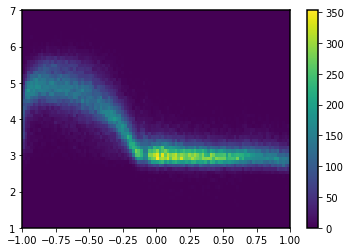

In [5]:
h = pl.hist2d(np.sin(icevents['Dec'] * degree), icevents['log10E'], bins=(100,61),range=([-1,1], [1,7]))
pl.colorbar(h[3])

### Average candidate neutrino rate

The range and duration of our sample is

In [6]:
print "From: ", min(icevents['MJD']), "to", max(icevents['MJD']), "(",max(icevents['MJD'])-min(icevents['MJD']), " days )"

From:  55694.0 to 56062.0 ( 368.0  days )


(55694.0, 56062.0)

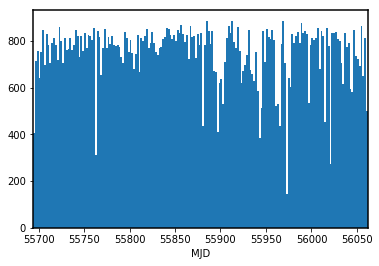

In [7]:
pl.hist(icevents['MJD'], bins=368/2, range=(55694, 56062))
pl.xlabel('MJD')
pl.xlim(min(icevents['MJD']), max(icevents['MJD']))

The rate is pretty flat, although not perfectly so. There are period with less neutrino candidates than average due to quality cuts implemented on the runs used in the analysis.

### Sky map

We'll use <a href='https://healpix.jpl.nasa.gov/'>HEALPix</a> to create counts map of neutrinos. The binning parameter *Nside* is set to 32, which means that the <a href='http://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm'>average pixel spacing</a> is ~1.8$^{\circ}$. This binning is now optimal for the PSF of IceCube, but it will allow us to look at features in the sky distribution of these neutrino event candidates.

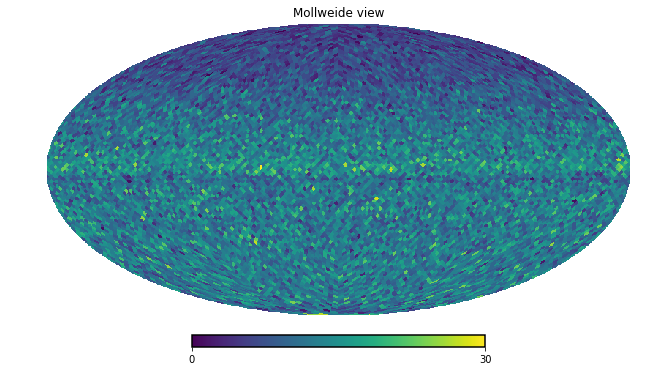

In [8]:
nside = 32
npixs = hp.nside2npix(nside)

# get HEALPix thetas and phis (in radians) from RA and Decs (in degrees)

def getThetaPhi(RA, Dec):
    theta = (90 - Dec) * degree
    phi = RA * degree
    return (theta, phi)


(theta, phi) = getThetaPhi(icevents['RA'], icevents['Dec'])

# Create and fill the map with events
hmap = np.zeros(npixs)
pixs = hp.ang2pix(nside, theta, phi)

for p in pixs:
    hmap[p] += 1
    
    
# Plot the map
hp.mollview(hmap, max=30)

The banding is a result of cuts and differences in the effective area for upgoing and downgoing events already described. The good news is that, on long time scales, the response of IceCube if fairly homogeneous in RA as shown in the plot below.

No obvious excess of events can be seen by eye, so we need to come up with a statistical test to look for sources.

Text(0.5,0,'$\\alpha$ [$^{\\circ}$]')

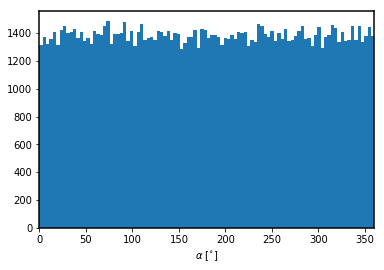

In [9]:
pl.hist(icevents['RA'],range=(0,360),bins=100)
pl.xlim(0,360)
pl.xlabel(r"$\alpha$ [$^{\circ}$]")

### Angular resolution

The angular resolution should improve vs energy, although it is a bit hard to see.

Text(0,0.5,'Angular error [$^{\\circ}$]')

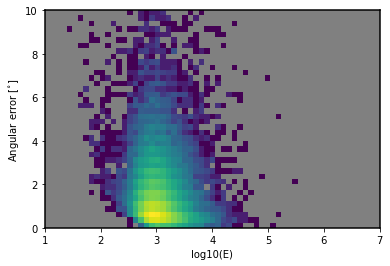

In [10]:
selection = (icevents['Dec'] > 0)

h1 = pl.hist2d(icevents[selection]['log10E'], icevents[selection]['ang_err'], bins=(61,40),range=([1,7], [0,10]), norm=mpl.colors.LogNorm())

#avg_err = []
#sigma_err = []

#for i in range(h1[0].shape[0]):
#    c = h1[0][i]
#    avg_err.append(np.average(c))
#    sigma_err.append(np.std(c))


pl.xlabel('log10(E)')
pl.ylabel('Angular error [$^{\circ}$]')

# Looking for hotspots

Let's start with something easy. We want to see if any of the event clusterings in the skymap is statistically significant. For that, we need to compare the number of detected events to what we would expect in that bin if there were no sources (the background-only hypothesis).

To estimate the background level, we scramble the RAs of the events while keeping the Dec constant and produce new maps. These maps have the same statistical properties as our 'real data' map but are scrambled so it should contain no significant structure.

We'll create 20 scrambles and add the maps together. 

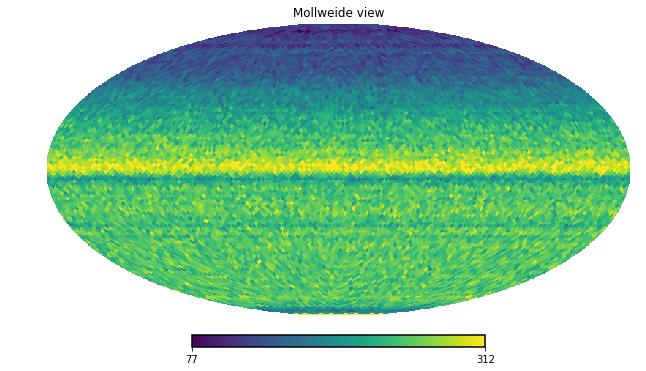

In [11]:
scramble_map = np.zeros(npixs)
Nscramble = 20

def scrambleRA(ras):
    return np.random.random(len(ras))*360

for s in range(Nscramble):
    ra = scrambleRA(icevents['RA'])
    
    (theta, phi) = getThetaPhi(ra, icevents['Dec'])
    
    pixs = hp.ang2pix(nside, theta, phi)

    for p in pixs:
        scramble_map[p] += 1
    
    
# Plot the map
hp.mollview(scramble_map, max=np.percentile(scramble_map, 99))

As you can see, the map has retained the declination features. The statistics are much higher (by x20) so it looks much smoother.

For each pixel, we now have a number of observed events and an expected number based on the scrambling method. Let's compare both and see what kind of statistical significances we get. For this crude example we'll use Eq. 17 of the the <a href="http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983ApJ...272..317L&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf">Li&Ma paper</a>  which is widely used in VHE gamma astronomy. 

Following the Li&Ma we set $\alpha = 1/20$ as our OFF/ON ratio (the ratio between the statistics in the "signal" and "background" maps).

In [12]:
def LiMa(Non, Noff, alpha):
    A = Non * np.log( ((1+alpha)/alpha)  * (Non/(Non+Noff)))
    B = Noff * np.log( (1+alpha)  * (Noff/(Non+Noff)))
    
    sign = np.ones(len(Non))

    sign[Non < Noff * alpha] = -1
    
    return sign * np.sqrt(2 * (A+B))

# This is a list of significances per pixel
sigma = LiMa(hmap, scramble_map, alpha=1/20.)

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Let's look at the map of significances and see what's the maximum significance in the map.

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


3.866930576197105


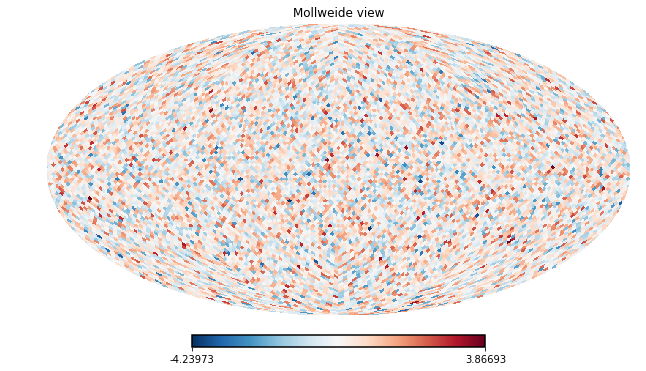

In [13]:
hp.mollview(sigma, cmap=cmap_maps, rot=180)
print(max(sigma))

Wow! a $>3\sigma$ excess! Should you publish a paper? Probably not, because you've looked at 12288 pixels in the sky, so finding $>3\sigma$ fluctuations is not *that* rare. Let's see how the significance histogram looks like.

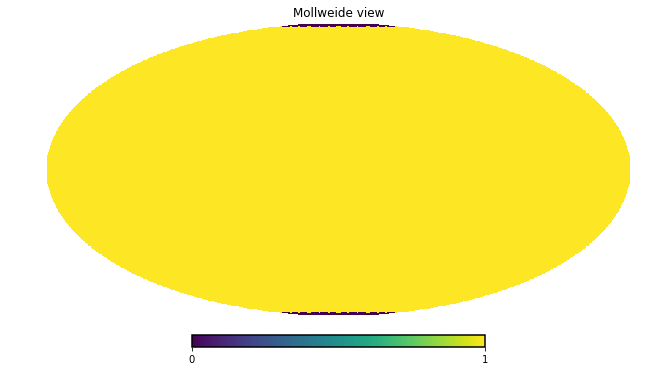

In [14]:
# Due to the way that the background is estimated, this doesn't work too well close to 
# the poles so we'll cut 5 degrees around each pole.

# O make me a mask
mask = np.ones(len(sigma))

(theta, phi) = hp.pix2ang(nside, range(len(sigma)))

mask[np.abs(90 * degree - theta) > 85 * degree] = 0

hp.mollview(mask)

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[8.29284964e+02 4.80832719e-02 9.74262263e-01]


(1, 1000)

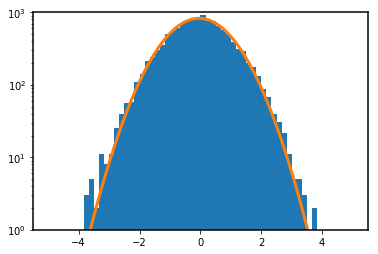

In [15]:
masked_sigma = mask * sigma

a = pl.hist(masked_sigma, bins=60, range=(-5,5))
pl.yscale('log')

s = np.linspace(-5,5,300)

def Gaussian(x, *p):
    return p[0] * np.exp(-(x + p[1])**2/(2*p[2]**2))

# A unit Gaussian looks like a reasoanable fit to the significance distribution, 
# and the excess looks consistent with background fluctuations.

from scipy.optimize import curve_fit
from scipy import optimize
p0 = [1000, 0, 1.]
bin_center = (a[1][1:] + a[1][:-1])/2.

coeff, var_matrix = curve_fit(Gaussian, bin_center, a[0], p0=p0)
print(coeff)

# Get the fitted curve
hist_fit = Gaussian(s, *coeff)

pl.plot(s, hist_fit, linewidth=3)

pl.ylim(1,1000)

### Trials

We said that the $3.7\sigma$ doesn't look too remarkable because we looked at many pixels. How can we quantify this?

* The easy way: if the p-value associated with the significance is small, we can just multiply it by the number of trials to get an 'after trials' p-value.

* The harder way: we can generate Monte Carlo simulations of the data (in our case, generate random data sets like the ones we used to estimate the background) and see how often we get a p-value better than the pre-trials one in random generations. The issue here is that if we have a small p-value, we would have to generate simulations to sample it.

In [16]:
def gauss_cdf(sigma):
    return 0.5 * (1 + sp.special.erf(sigma/np.sqrt(2)))

# we calculate the p-value associated with the significance
smax = 3.6
pvalue = 1 - gauss_cdf(smax)

# the number of trials in the number of pixels
ntrials = len(masked_sigma)

paftertrials = ntrials * pvalue

print "Pre-trials p:", pvalue
print "Post-trials p:", paftertrials

Pre-trials p: 0.00015910859015755285
Post-trials p: 1.9551263558560095


The post-trials p-value is >1, which is obviously something you don't want in a p-value, but it esentially means that the post-trials p-value is not significant and to actually get a good estimate we would have to do so Monte Carlo, we we won't...

## Other angular scales

So far, we've looked for a neutrino hotspot on each pixel individually, but the pixel size (1.8°) is larger than the PSF of IceCube (~< 1°), and it could also be that the size is larger than the PSF for a extended Galactic source.

We can explore other angular scales by "smoothing" the map, which correlates pixels over a larger angular scale than the pixel size. Let's see how the map looks when we smooth it by 2° radius. For this we'll start with a higher resolution map which we'll smooth.

In [17]:
smooth_radius = 2 * degree

nside = 128
npixs = hp.nside2npix(nside)

(theta, phi) = getThetaPhi(icevents['RA'], icevents['Dec'])

# Create and fill the map with events
hmap = np.zeros(npixs)
pixs = hp.ang2pix(nside, theta, phi)

for p in pixs:
    hmap[p] += 1
    

def smooth_map(hmap, radius=3*degree):
    smap = np.zeros(len(hmap))
    
    for i in range(npixs):
        v = hp.pix2vec(nside,i)
        qpixs = hp.query_disc(nside,v, radius=radius)
        smap[i] = np.sum(hmap[qpixs])
    
    return smap

smap = smooth_map(hmap, smooth_radius)

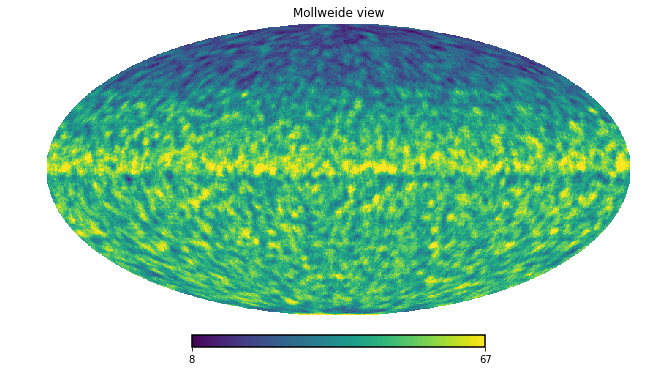

In [18]:
hp.mollview(smap,  max=np.percentile(smap, 99))

In [19]:
scramble_map = np.zeros(npixs)
Nscramble = 20

def scrambleRA(ras):
    return np.random.random(len(ras))*360

for s in range(Nscramble):
    ra = scrambleRA(icevents['RA'])
    
    (theta, phi) = getThetaPhi(ra, icevents['Dec'])
    
    pixs = hp.ang2pix(nside, theta, phi)

    for p in pixs:
        scramble_map[p] += 1

smap_scramble = smooth_map(scramble_map, smooth_radius)

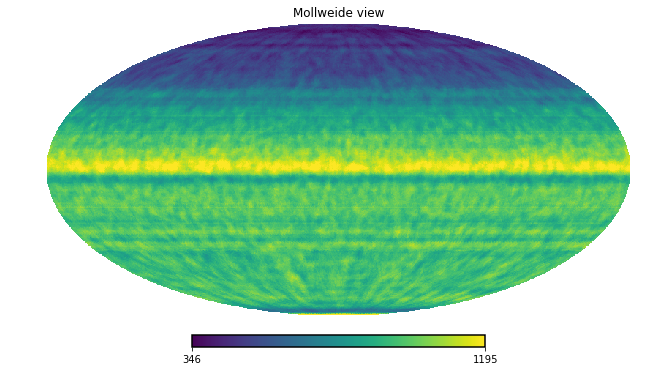

In [20]:
# Plot the map
hp.mollview(smap_scramble, max=np.percentile(smap_scramble, 99))

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
4.686872080903177


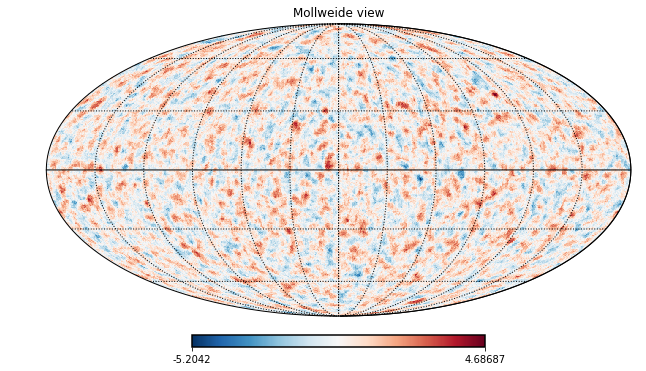

In [21]:
sigma_smooth = LiMa(smap, smap_scramble, alpha=1/20.)
hp.mollview(sigma_smooth, cmap=cmap_maps, rot=180)
hp.graticule()
print(max(sigma_smooth))

Let's zoom in into the location of the excess to see how it looks.

Max significance: 4.686872080903177
Pixel with max sigma 36193
(68.203125, 39.065494664452594)
(68.203125, 39.065494664452594)
1.65540258048 100.213608091 4.73397568921 131.672274311
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


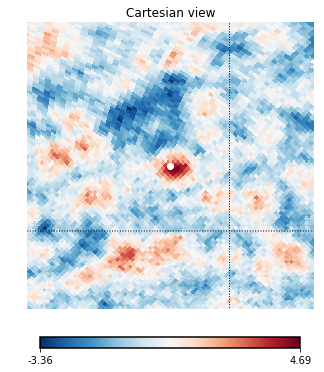

In [22]:
pixmax = np.argmax(sigma_smooth)
print "Max significance:",  max(sigma_smooth)
print "Pixel with max sigma", pixmax

(thetamax, phimax) = hp.pix2ang(nside, pixmax)

ramax = phimax/degree
decmax = 90 - thetamax / degree

print(ramax, decmax)

lonmax = ramax
if lonmax > 180:
    lonmax = -360 + lonmax

box = 20

print(lonmax, decmax)

hp.cartview(sigma_smooth, latra=[decmax-box, decmax+box], \
            lonra=[lonmax-box, lonmax+box], cmap=cmap_maps)
hp.projscatter(thetamax, phimax, color='white', marker='o')

hp.graticule()

[1.32019698e+04 3.58006993e-02 9.88345507e-01]


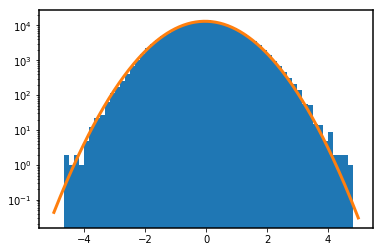

In [23]:
# Create a new mask
smask = np.ones(npixs)

(theta, phi) = hp.pix2ang(nside, range(npixs))

smask[np.abs(90 * degree - theta) > 85 * degree] = 0

masked_sigma_smooth = smask * sigma_smooth

a = pl.hist(masked_sigma_smooth, bins=60, range=(-5,5))
pl.yscale('log')


s = np.linspace(-5,5,300)

def Gaussian(x, *p):
    return p[0] * np.exp(-(x + p[1])**2/(2*p[2]**2))

# A unit Gaussian looks like a reasoanable fit to the significance distribution, 
# and the excess looks consistent with background fluctuations.

from scipy.optimize import curve_fit
from scipy import optimize
p0 = [1000, 0, 1.]
bin_center = (a[1][1:] + a[1][:-1])/2.

coeff, var_matrix = curve_fit(Gaussian, bin_center, a[0], p0=p0)
print(coeff)

# Get the fitted curve
hist_fit = Gaussian(s, *coeff)

pl.plot(s, hist_fit, linewidth=3)



There's now something a little higher in significance (4.4), let's correct for trials. You may get slightly different values which could be related to background fluctuations. To reduce this you can generate more background realizations.  

We could claim that this is the first time we've looked at a skymap, but the fact that we've now looked at two angular scales (pixel size and 2 deg smoothing) has to be accounted for somehow in our correction. We just use 2 as the number of trials due to angular scales examined.

In [24]:
# we calculate the p-value associated with the significance
smax = 4.4
pvalue = 1 - gauss_cdf(smax)

# the number of trials in the number of pixels
ntrials_pix = len(masked_sigma) 

# number of trials due to angular scales examined
ntrials_ang = 2

paftertrials = ntrials_pix * ntrials_ang * pvalue

print "Pre-trials p:", pvalue
print "Post-trials p:", paftertrials

Pre-trials p: 5.412543907734602e-06
Post-trials p: 0.13301867907648557


## What about Fermi sources?

Again, a disclaimer as this is just an illustration of an idea!

In [25]:
urllib.urlretrieve('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v16.fit',\
                   'gll_psc_v16.fit')

hdulist = fits.open('gll_psc_v16.fit')
h, data, columns = hdulist[1].header, hdulist[1].data, hdulist[1].columns

sel = np.abs(data['GLAT']) > 5

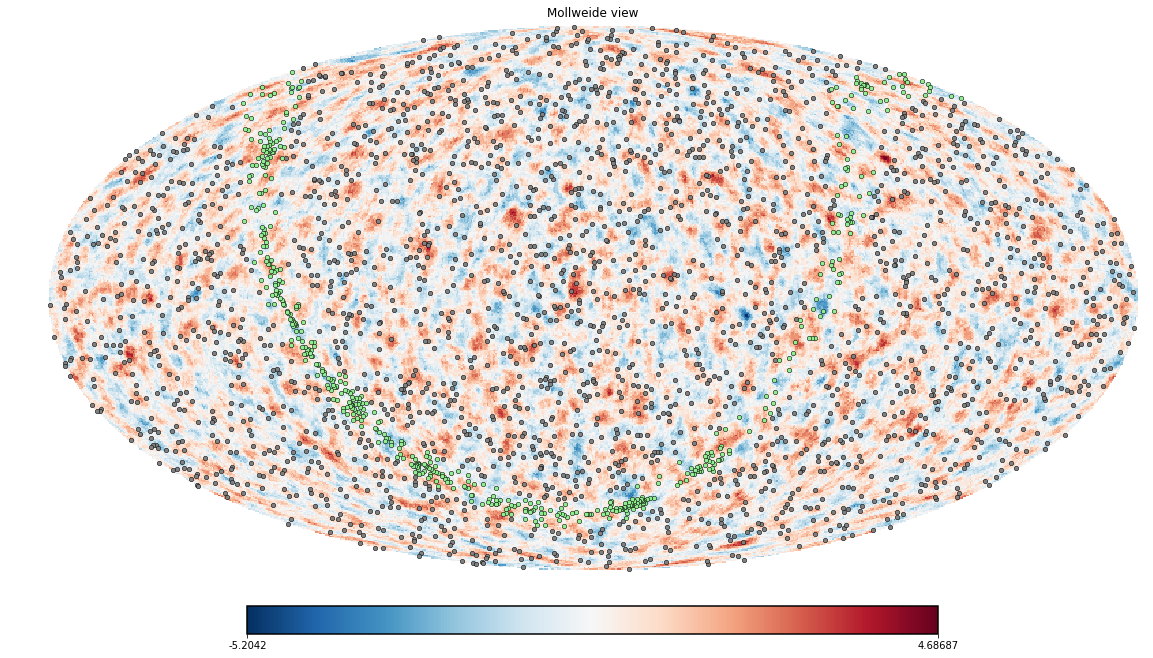

In [26]:
fig = pl.figure(figsize=(20,10))
hp.mollview(sigma_smooth, fig=1, cmap=cmap_maps, rot=180)
hp.projscatter(data[sel]['RAJ2000'], data[sel]['DEJ2000'], lonlat=True, s=20, color='gray', marker='o', linewidth=0.5, edgecolor='black')
hp.projscatter(data[~sel]['RAJ2000'], data[~sel]['DEJ2000'], lonlat=True, s=20, color='lightgreen', marker='o', linewidth=0.5, edgecolor='black')


#hp.graticule()

In [27]:
radscan = np.linspace(0.3,10, num=100)

Nons = []
Noffs = []

hmap_masked = smask * hmap
scramble_map_masked = scramble_map * smask

for radius in radscan:

    Non = 0
    Noff = 0

    # Let's only look at "extragalactic" sources
    
    for s in data[np.abs(data['GLAT']) > 5]:
        theta = (90 - s['DEJ2000']) * degree
        phi = s['RAJ2000'] * degree
    
        v = hp.ang2vec(theta,phi)
        pixs = hp.query_disc(nside,v,radius*degree)
        
        Non += np.sum(hmap_masked[pixs])
        Noff += np.sum(scramble_map_masked[pixs])
    
    Nons.append(Non)
    Noffs.append(Noff)

Text(0,0.5,'Significance [$\\sigma$]')

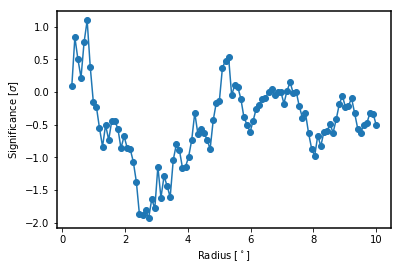

In [28]:
sigscan = LiMa(np.array(Nons),np.array(Noffs), 1/20.)
pl.plot(radscan, sigscan,marker='o')
pl.xlabel('Radius [$^\circ$]')
pl.ylabel('Significance [$\sigma$]')

# Unbinned likelihood analysis

We'll use the standard IceCube ps analysis method. A good description is available in <a href='https://docushare.icecube.wisc.edu/dsweb/Get/Document-72853/Feintzeig_Thesis.pdf'>Jake Feintzeig's thesis (Chapter 6)</a>.

We'll simplify the search to fit only for the number of source events ($n_s$), so the likelihood reads:

${\cal L}(n_s) = \Pi_i \frac{n_s}{N} {\cal S}_i + (1 - \frac{n_s}{N}) {\cal B}_i$

Over all events (i) in the sample. We'll take a log of the likelihood function, so the equation becomes a sum.


In [29]:
def openingAngle(ra0, dec0, ra1, dec1):
    v0 = hp.ang2vec(ra0, dec0, lonlat=True)
    v1 = hp.ang2vec(ra1, dec1, lonlat=True)
    
    dp = np.dot(v0,v1)
    return np.arccos(dp) / degree


def getBkgFunction(icevents):
    sinBins = 40
    histo = np.histogram(np.sin(icevents['Dec'] * degree),range=(-1,1),bins=sinBins)

    ds = 2./sinBins
    A = len(icevents) * ds * 2*np.pi
    
    bincenters = (histo[1][1:] + histo[1][:-1]) / 2.
    counts = histo[0] / A
    func = UnivariateSpline(bincenters, counts, s=0)
    return func


def LLHFunction(events, raS, decS, ns, bkg):
    # We need the position, angular resolution, and total number of events. 
    # We also need the background distribution of events in sin(delta)
    
    raEvent = events['RA']
    decEvent = events['Dec']
    angres = events['ang_err']
    
    N = len(events)
    
    r = openingAngle(raEvent, decEvent, raS, decS)
    S = np.exp(-r**2/(2*angres**2)) / (2 * np.pi * (angres*degree)**2)
    
    B = bkg(np.sin(decEvent * degree))

    llh = np.log(ns * S / float(N) + (1 - ns/float(N)) * B)
    
    return llh[llh == llh]




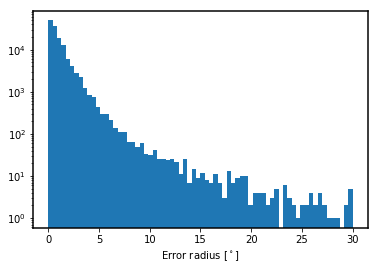

In [30]:
a = pl.hist(icevents['ang_err'],range=(0,30),bins=70)
pl.xlabel('Error radius [$^\circ$]')
pl.yscale('log')

Text(0,0.5,'$\\delta [^{\\circ}$]')

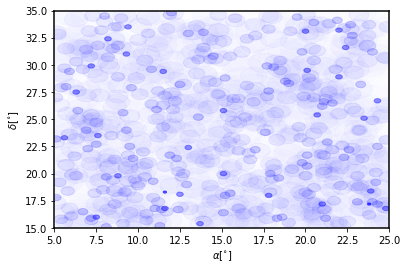

In [31]:
fig, ax = pl.subplots()

dra = 10
ddec = 10

ra0 = 15
dec0 = 25

for event in icevents:
    if np.abs(event['RA'] - ra0) < dra and np.abs(event['Dec'] - dec0) < ddec:
        areaPSF = np.pi * event['ang_err']**2
        c1 = pl.Circle((event['RA'], event['Dec']), event['ang_err'], color='blue', alpha=0.05/areaPSF)
        ax.add_artist(c1)

#pl.scatter(icevents['RA'], icevents['Dec'])
pl.xlim(ra0-dra,ra0+dra)
pl.ylim(dec0-ddec,dec0+ddec)
pl.xlabel(r'$\alpha [^{\circ}$]')
pl.ylabel(r'$\delta [^{\circ}$]')

In [113]:
raS = 208.1
decS = 23
N = len(icevents)

nsources = np.linspace(0, 50, num=100)
bkg = getBkgFunction(icevents)

llhs = []

from scipy.optimize import minimize

for ns in nsources:
    llhs.append(-np.sum(LLHFunction(icevents, raS, decS, ns, bkg)))
    

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


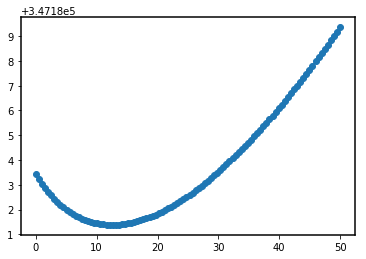

In [57]:
pl.plot(nsources, llhs, marker='o')

In [93]:
from iminuit import Minuit, describe, Struct

In [110]:
def f(ns, raS, decS):
    return -np.sum(LLHFunction(icevents, raS, decS, ns, bkg))
    
m=Minuit(f, ns=10, error_ns=0.1, limit_ns=(0,200), print_level=0, \
         raS = raS, \
         decS = decS, \
         fix_raS=True, \
         fix_decS=True, \
         forced_parameters=['ns', 'raS', 'decS'])

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: errordef is not given. Default to 1.
  after removing the cwd from sys.path.


In [111]:
m.migrad();
m.print_param()#or call print_initial_param

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,ns,12.5371,10.3205,0,0,0.0,200.0,
2,raS,208.1,1,0,0,,,FIXED
3,decS,23,1,0,0,,,FIXED


### Now let's try more points

In [119]:
nsFit = []
logLFit = []

logL0Fit = []

for raS in np.linspace(200, 210, 10): 
    
    for decS in np.linspace(20,30, 10):
        m=Minuit(f, ns=10, error_ns=0.1, limit_ns=(0,200), print_level=0, \
         raS = raS, \
         decS = decS, \
         fix_raS=True, \
         fix_decS=True, \
         forced_parameters=['ns', 'raS', 'decS'])
        
        m.migrad()
        
        nsFit.append(m.values['ns'])
        logLFit.append(m.fval)
        logL0Fit.append(-np.sum(LLHFunction(icevents, raS, decS, 0, bkg)))

        

/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:9: InitialParamWarning: errordef is not given. Default to 1.
  if __name__ == '__main__':
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:9: InitialParamWarning: errordef is not given. Default to 1.
  if __name__ == '__main__':
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/ipykernel_launcher.py:9: InitialParamWarning: errordef is not given. Default to 1.
  if __name__ == '__main__':
/home/astrosoft/sciencetools/x86_64-unknown-linux-gn

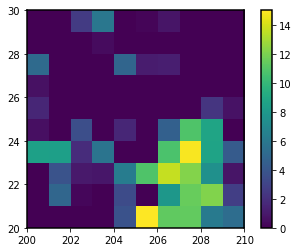

In [128]:
b = pl.imshow(np.array(nsFit).reshape(10,10).T, origin='lower', extent=[200,210,20,30])
pl.colorbar(b)

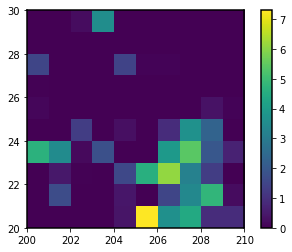

In [133]:
TS = -2 * (np.array(logLFit) - np.array(logL0Fit))
b = pl.imshow(np.array(TS).reshape(10,10).T, origin='lower', extent=[200,210,20,30])
pl.colorbar(b)